# 1. Install Dependencies and Setup

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# this is not detecting my GPU, so it's not doing anything for me on my machine
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Remove bad images

In [24]:
import cv2
import imghdr


In [11]:
data_dir = 'data'

In [13]:
image_exts = ['jpg', 'jpeg', 'png', 'bmp']

In [20]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list: ", image_path)
                os.remove(image_path)
        except Exception as e:
            print("Error loading image: ", image_path)
            os.remove(image_path)

# 3. Load Data

In [25]:
import numpy as np
from matplotlib import pyplot as plt

In [78]:
# look in image directory and build dataset based on file structure
# builds data pipeline
data = tf.keras.utils.image_dataset_from_directory('data')

Found 171 files belonging to 2 classes.


In [28]:
# allows access to the data as numpy arrays. works similar to a generator
# need for access to pipeline data
data_iterator = data.as_numpy_iterator()

In [42]:
# actually accessing data in pipeline. each batch will have two parts, images and labels
batch = data_iterator.next()

In [43]:
# shows that this batch has 32 images that are all sized 256x256 and three color channels
# all this is done for me by image_dataset_from_directory function
# images are represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [44]:
# represents the labels for each image in the batch
# in this case since there are two classes each image will have a label of 0 or 1 (for happy or sad)
# 1 has been assigned as sad and 0 has been assigned as happy
batch[1]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1])

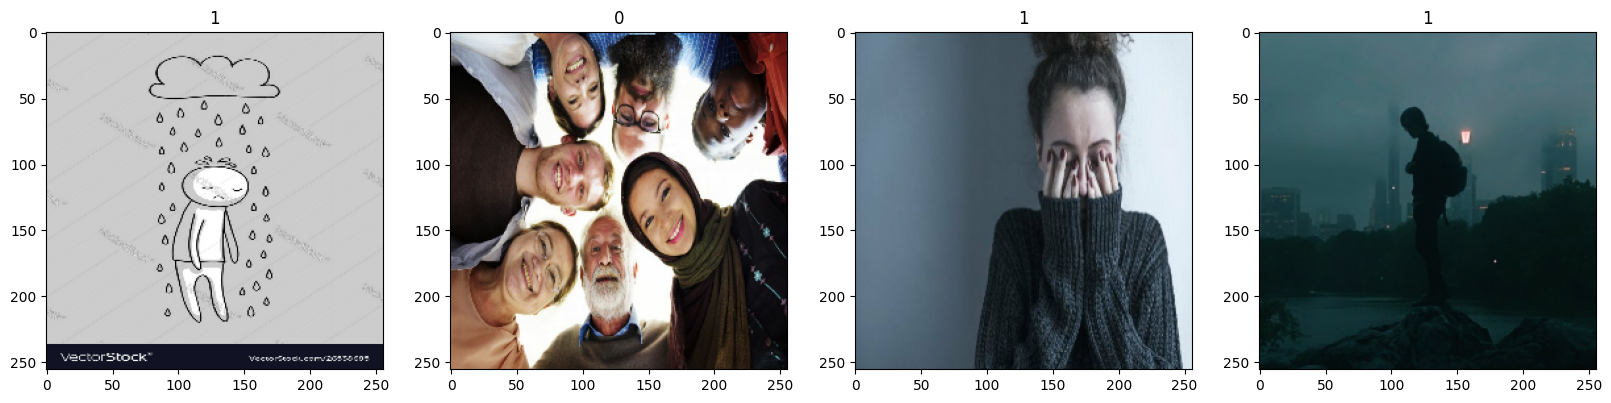

In [45]:
# show images from the first batch and see their labels
fix, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [79]:
# change color values of pixels from 0-255 to 0-1. 
data = data.map(lambda x, y: (x / 255.0, y))

In [81]:
scaled_iterator = data.as_numpy_iterator()

In [82]:
batch = scaled_iterator.next()

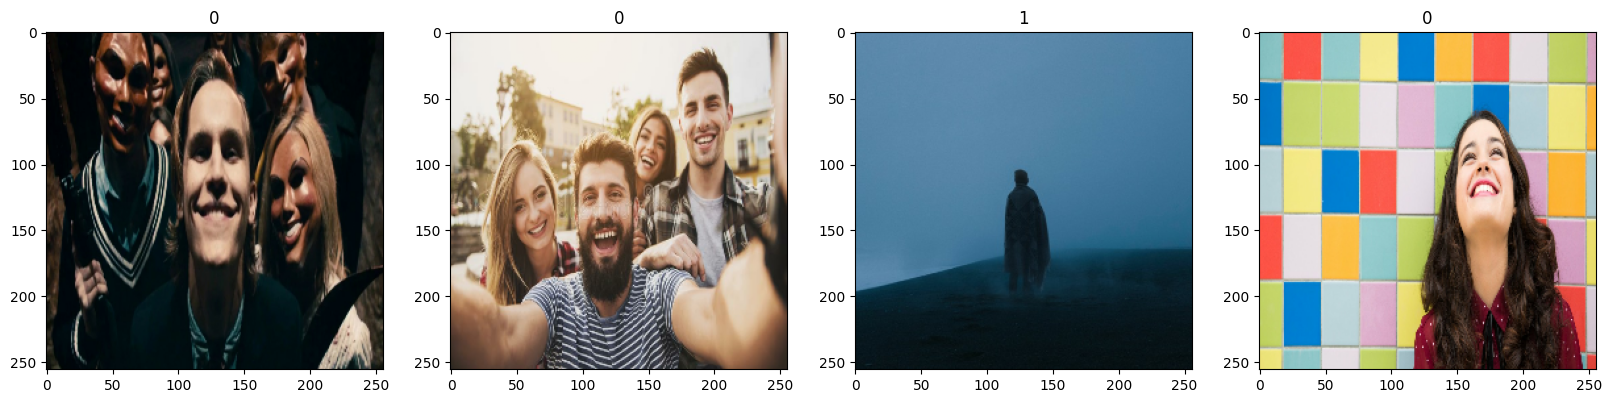

In [83]:
fix, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) # no need to cast to int since values are now 0-1
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data into training and testing partitions

In [70]:
# data is chunked into six batches of 32 images
len(data)

6

In [73]:
# training images with be 3 batches
train_size = int(len(data)*.7) - 1

# validation images will be 2 batch
val_size = int(len(data)*.2) + 1

# test images will be 1 batch
test_size = int(len(data)*.1) + 1

In [74]:
# use take and skip methods to split data into train, val, and test
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).skip(val_size).take(test_size)

# 6. Build Deep Learning Model

In [86]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [85]:
model = Sequential()

In [91]:
# first layer. convolutional layer with 16 filters, 3x3 px size, stride of 1, input shape of 256x256x3 (img size and color channels)
model.add(Conv2D(16, (3,3),1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())   # takes max value from 2x2 px area

model.add(Conv2D(32, (3,3),1, activation='relu'))   # 32 filters, 3x3 px size, stride of 1
model.add(MaxPooling2D())   # takes max value from 2x2 px area

model.add(Conv2D(16, (3,3),1, activation='relu'))   # 16 filters, 3x3 px size, stride of 1
model.add(MaxPooling2D())   # takes max value from 2x2 px area

model.add(Flatten())    # flattens data into 1D array

model.add(Dense(256, activation='relu'))    # fully connected layer with 256 neurons
model.add(Dense(1, activation='sigmoid'))   # output layer with 1 neuron. output will be 0 or 1

In [160]:
# actually compile the model and set the loss function and track accuracy as the metric
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [161]:
# summary data on what each layer is doing
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

# 7. Train

In [97]:
# create a directory for logs
logdir = 'logs'

In [98]:
# callback function to write logs to the directory
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [162]:
# store the history of the training. can be used to plot accuracy and loss over time
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 3s 791ms/step - loss: 0.6764 - accuracy: 0.8750 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 3s 735ms/step - loss: 0.2131 - accuracy: 0.9062 - val_loss: 0.1546 - val_accuracy: 0.9219
Epoch 3/20
3/3 [==============================] - 3s 771ms/step - loss: 0.1120 - accuracy: 0.9479 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 3s 767ms/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 3s 792ms/step - loss: 0.0714 - accuracy: 0.9896 - val_loss: 0.0738 - val_accuracy: 0.9844
Epoch 6/20
3/3 [==============================] - 3s 882ms/step - loss: 0.0704 - accuracy: 0.9896 - val_loss: 0.0788 - val_accuracy: 0.9844
Epoch 7/20
3/3 [==============================] - 3s 872ms/step - loss: 0.0597 - accuracy: 0.9896 - val_loss: 0.0388 - val_accuracy: 0.9844
Epoch 8/20
3/3 [====

# 8. Plot Performance

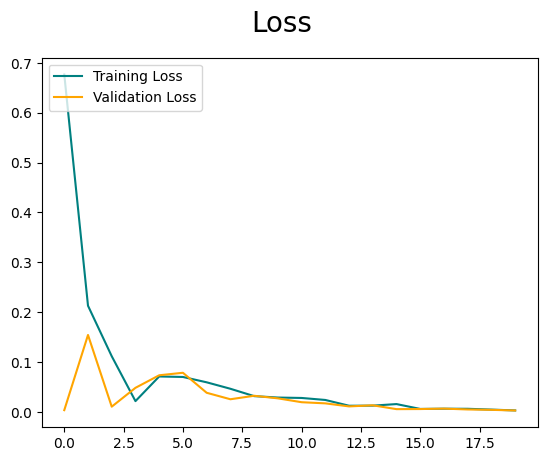

In [163]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')

# trend on graph should be down over time. if not then the model may be overfitting
plt.show()

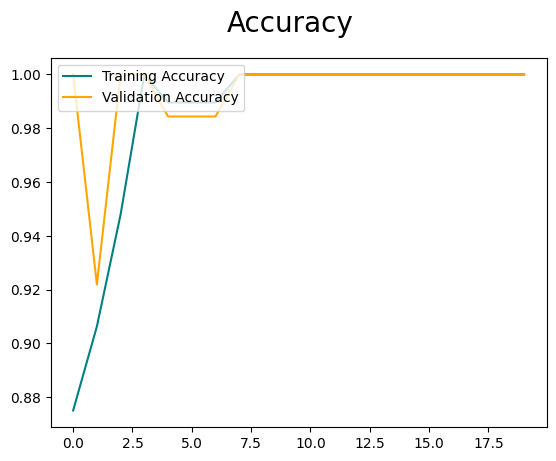

In [164]:
git = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
git.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')

# trend in the graph should be up over time.
plt.show()

# 9. Evaluate

In [104]:
from tensorflow.python.keras.metrics import Precision, Recall, BinaryAccuracy

In [105]:
# instantiate the metrics
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [165]:
# loop through each batch in the test data to test the models accuracy, precision, and recall
for batch in test.as_numpy_iterator():
    x, y = batch                            # split batch into images and labels
    predicted_val = model.predict(x)        # get predictions from model if the image is happy or sad
    pre.update_state(y, predicted_val)      # update the precision metric with the actual label and the predicted label
    re.update_state(y, predicted_val)       # update the recall metric with the actual label and the predicted label
    acc.update_state(y, predicted_val)      # update the accuracy metric with the actual label and the predicted label

In [166]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


# 10. Test

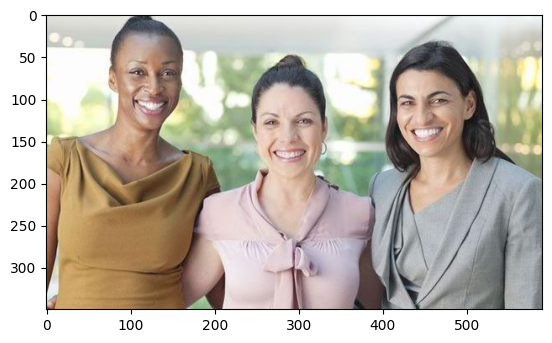

In [167]:
img = cv2.imread('happy_test_2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

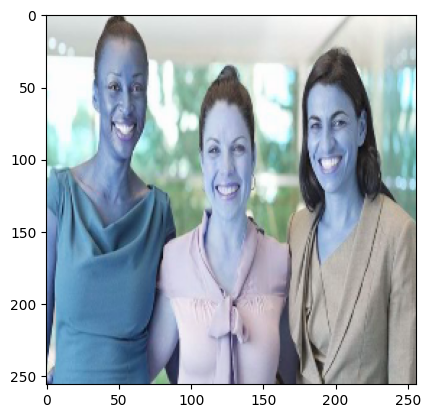

In [168]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# color doesn't matter at this point. just need to make sure the image is the same size as the training images

In [169]:
# expand_dims adds a dimension to the array. this is needed because the model expects a batch of images
# divide by 255 to scale the values from 0-255 to 0-1
predicted_val = model.predict(np.expand_dims(resize/255, 0))

In [170]:
predicted_val

array([[0.8135842]], dtype=float32)

In [171]:
if predicted_val > .5:
    print('Predicted class is Sad')
else:
    print('Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [144]:
from tensorflow.python.keras.models import load_model

In [146]:
# save the model as an h5 file. similar to a zip file
model.save(os.path.join('models', 'happy_sad_model.h5'))

In [147]:
# loading the model
new_model = load_model(os.path.join('models', 'happy_sad_model.h5'))

In [150]:
# pass resized image to the model again to get the same prediction
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.9378021]], dtype=float32)